# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [61]:
student1 = "Amaury Combes"
student2 = "Vincenzo Bazzucchi"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [78]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

import itertools

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(235400 + 249733)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [64]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [65]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

In [66]:
x_test.shape

(13345, 256)

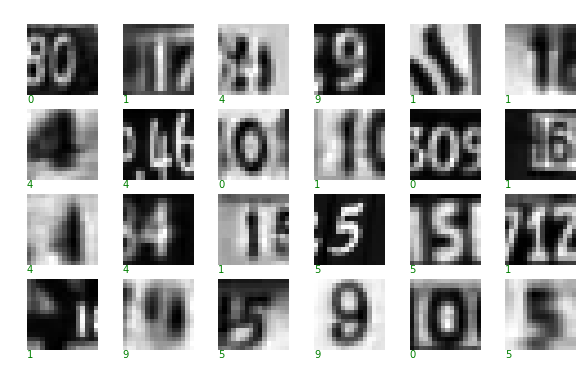

In [67]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [68]:
y_test_class = np.array(y_test.copy())

In [69]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Here we use the `EarlyStopping` callback to ensure point 7: it will stop the learning process when the validation loss stops decreasing for 5 iterations. As discussed in the forum, with early stopping we mean a different behavior. Below we try to provide a simple implementation of this regularization technique.

In [28]:
model = Sequential([
    Dense(y_train.shape[1], input_shape=(x_train.shape[1],), activation="softmax")
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=0.1), #find params
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, batch_size=128,
    #callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5, min_delta=0.001)]
)

Train on 37808 samples, validate on 13345 samples
Epoch 1/50
37808/37808 [==============================] - 1s 17us/step - loss: 1.5241 - acc: 0.3638 - val_loss: 1.5044 - val_acc: 0.3834
Epoch 2/50
37808/37808 [==============================] - 0s 13us/step - loss: 1.5022 - acc: 0.3743 - val_loss: 1.5020 - val_acc: 0.4078
Epoch 3/50
37808/37808 [==============================] - 1s 13us/step - loss: 1.4935 - acc: 0.3834 - val_loss: 1.4884 - val_acc: 0.4179
Epoch 4/50
37808/37808 [==============================] - 0s 12us/step - loss: 1.4865 - acc: 0.3899 - val_loss: 1.4957 - val_acc: 0.4290
Epoch 5/50
37808/37808 [==============================] - 0s 13us/step - loss: 1.4825 - acc: 0.3947 - val_loss: 1.4879 - val_acc: 0.4133
Epoch 6/50
37808/37808 [==============================] - 0s 13us/step - loss: 1.4786 - acc: 0.3987 - val_loss: 1.4880 - val_acc: 0.4263
Epoch 7/50
37808/37808 [==============================] - 0s 13us/step - loss: 1.4754 - acc: 0.4024 - val_loss: 1.4963 - val_acc

In [29]:
for metric, value in zip(model.metrics_names, model.evaluate(x_test, y_test)):
    print(metric, '=', value)

13345/13345 [==============================] - 0s 20us/step
loss = 1.50615151344
acc = 0.438965904833


The validation loss is constant around $\approx 1.50$

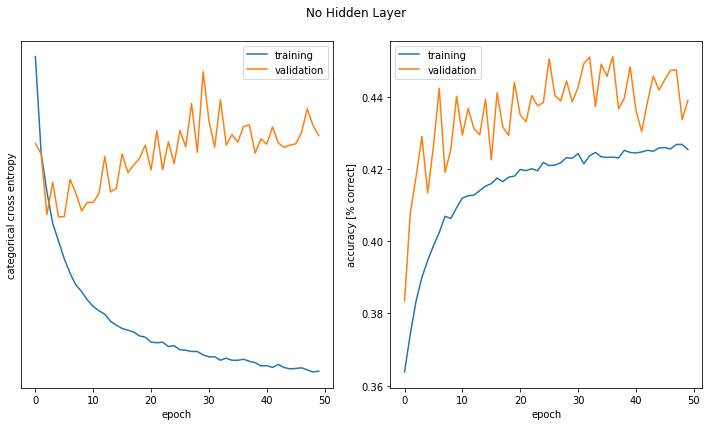

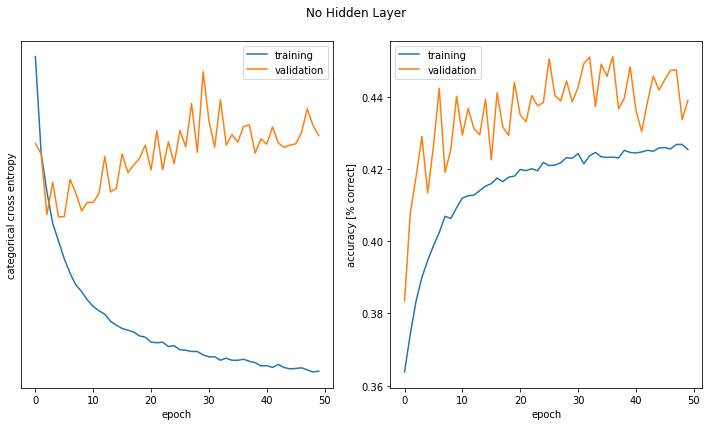

In [30]:
plot_history(history, "No Hidden Layer") # if do not store in var is displayed twice...

In [31]:
y_hat = model.predict_classes(x_test)

In [52]:
misclassified_indicator = np.where(y_hat != y_test_class)[0]

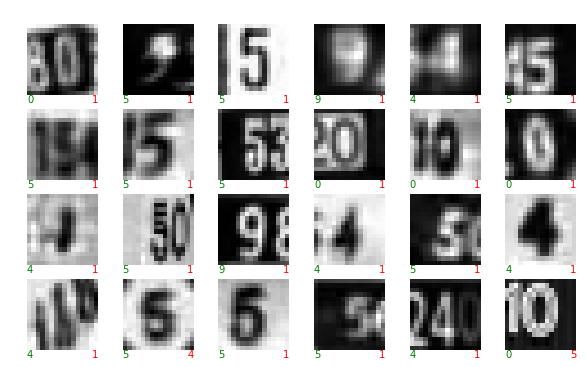

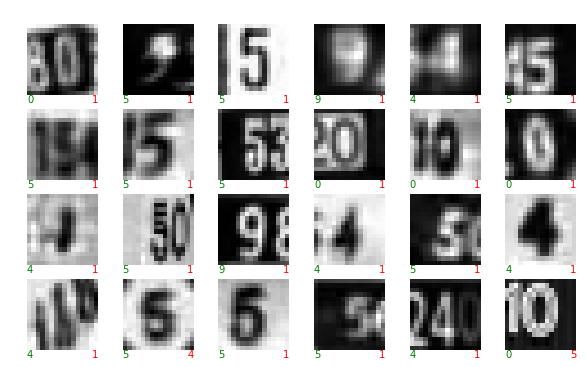

In [73]:
plot_some_samples(
    x_test[misclassified_indicator],
    y_test_class[misclassified_indicator],
    y_hat[misclassified_indicator],
    label_mapping=subset_of_classes
)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

#### Question 1

In [12]:
model = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=0.01),
    metrics=['accuracy']
)

historySGD = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


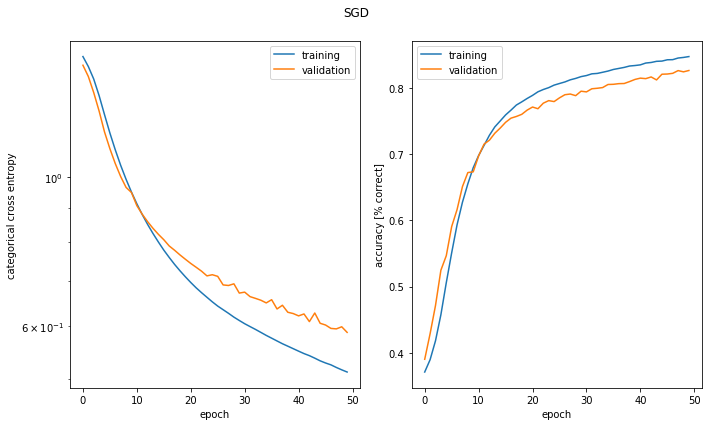

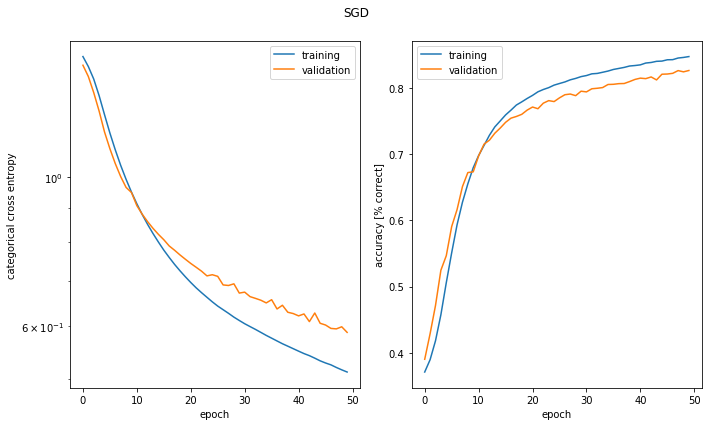

In [14]:
plot_history(historySGD, "SGD") # if do not store in var is displayed twice...

#### Question 2

In [15]:
LARGE_RATE = 0.9
SMALL_RATE = 10**(-6)

In [16]:
sgd_test_rate = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

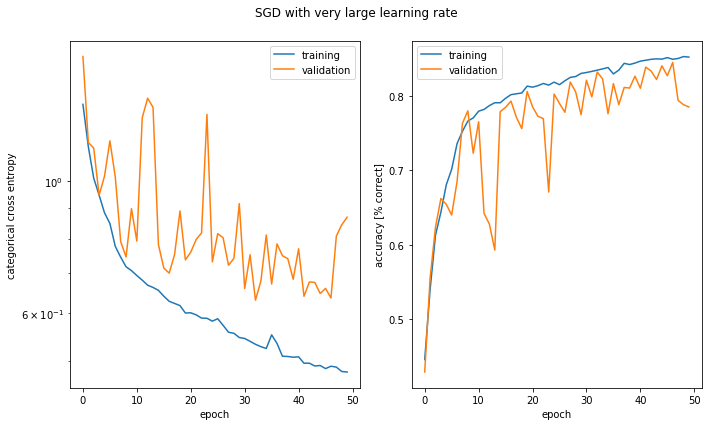

In [17]:
sgd_test_rate.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=LARGE_RATE),
    metrics=['accuracy']
)

_ = plot_history(sgd_test_rate.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
), "SGD with very large learning rate")

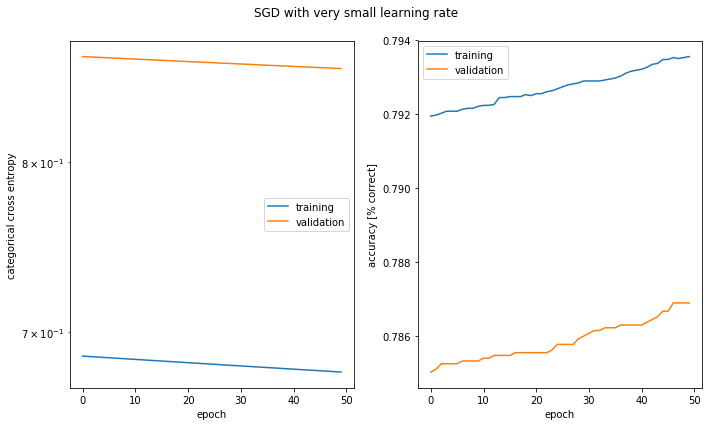

In [18]:
sgd_test_rate.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=SGD(lr=SMALL_RATE),
    metrics=['accuracy']
)

_ = plot_history(sgd_test_rate.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
), "SGD with very small learning rate")

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The validation error and accuracy are very "unstable", the search for the optimal value goes in the wrong direction many times

B) The improvement is very slow but constant: we would need three times the number of epochs to reach the best result obtained with the larger learning rate

#### Question 3

In [19]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

historyAdam = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    verbose=0
)

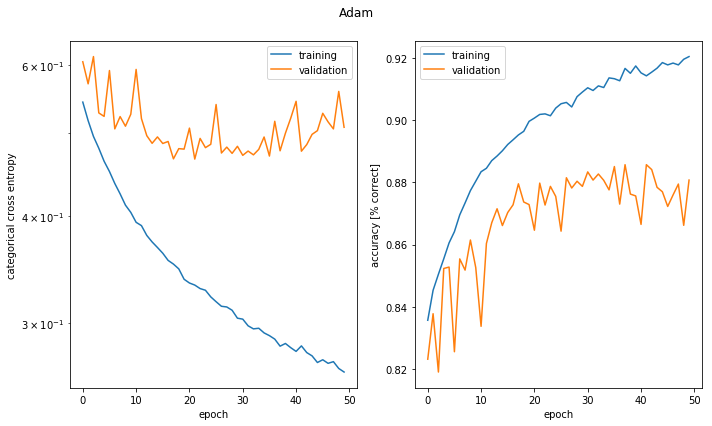

In [20]:
_ = plot_history(historyAdam, "Adam") # if do not store in var is displayed twice...

Using the same learning rate with Adam and SGD does not allow Adam to improve its accuracy, therefore we changed it here

#### Question 4

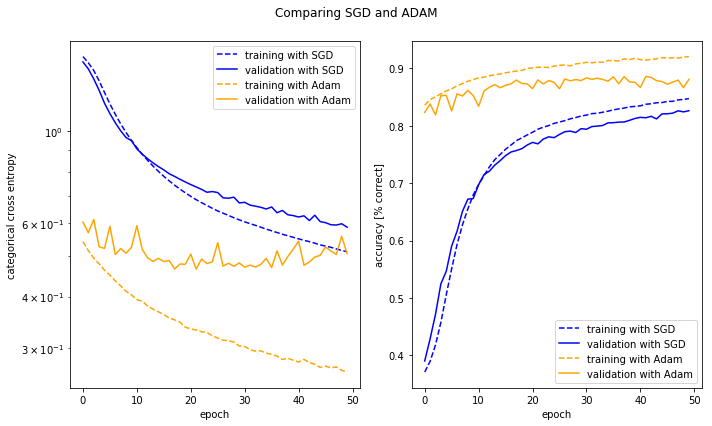

In [21]:
fig, ax1, ax2 = prepare_standardplot("Comparing SGD and ADAM", 'epoch')
ax1.plot(historySGD.history['loss'], label = "training with SGD", linestyle='--', c='b')
ax1.plot(historySGD.history['val_loss'], label = "validation with SGD", linestyle='-', c='b')
ax2.plot(historySGD.history['acc'], label = "training with SGD", linestyle='--', c='b')
ax2.plot(historySGD.history['val_acc'], label = "validation with SGD", linestyle='-', c='b')

ax1.plot(historyAdam.history['loss'], label = "training with Adam", linestyle='--', c='orange')
ax1.plot(historyAdam.history['val_loss'], label = "validation with Adam", linestyle='-', c='orange')
ax2.plot(historyAdam.history['acc'], label = "training with Adam", linestyle='--', c='orange')
ax2.plot(historyAdam.history['val_acc'], label = "validation with Adam", linestyle='-', c='orange')
finalize_standardplot(fig, ax1, ax2)

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [ ]:
_ = plot_history(historyAdam, "Adam") # if do not store in var is displayed twice...

The training we ran before was already overfitting: we can clearly see that the training error keeps decreasing while the validation error stays stable. We can see the same pattern observing the accuracy: the training accuracy keeps increasing while the validation accuracy is mostly stable

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: The model start to overfit right away but after epoch 15 we clearly see that the validation error stays stable or increases while the training error keeps decreasing

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: # TODO

As discussed in the forum, we should not use `keras.callbacks.EarlyStopping`. Therefore we implemented early stopping as described in the Deeplearning book: each time the validation accuracy improves, we take a snapshot of the model weights

In [ ]:
class RealEarlyStopper(keras.callbacks.Callback):
    def __init__(self, set_best_at_end=True):
        self._best_score = -1
        self._best_weights = None
        self._set_best_at_end = set_best_at_end
    
    def on_epoch_end(self, epoch=None, logs={}):
        valacc = logs['val_acc']
        if valacc > self._best_score:
            self._best_score = valacc
            self._best_weights = [layer.get_weigths().copy() for layer in self.model.layers]
        
    def on_train_end(self, logs={}):
        if not self._set_best_at_end:
            return
        for layer, best_weights in zip(self.model.layers, self._best_weights):
            layer.set_weights(best_weights)

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

As we observed from our previous plots, the Adam optimizer converges much quicker than the SGD one. Therefore we will use it here. We saw that the model start to overfit at around 15 so we will train it for 30 epochs

In [74]:
def get_model_result(hidden_neurons):
    m = Sequential([
        Dense(hidden_neurons, input_shape=(x_train.shape[1],), activation="relu"),
        Dense(y_train.shape[1], activation="softmax")
    ])
    
    m.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=Adam(lr=0.001),
        metrics=['accuracy']
    )

    h = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=30,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3, min_delta=0.001)]
    )
    
    return h.history['val_loss'][-1], h.history['val_acc'][-1]

#### Questions 1 and 2

In [75]:
N = 20
hidden_neurons = list(map(int, np.logspace(1, 3, N)))
stats = []
for idx, hid in enumerate(hidden_neurons):
    # This seed or the seed parameter of initializer?
    # https://keras.io/initializers/
    np.random.seed(hash(student1 + student2) % 2**32)
    stats.append(get_model_result(hid))
    print("Completed train {}/{}".format(idx+1, N))

Completed train 1/20
Completed train 2/20
Completed train 3/20
Completed train 4/20
Completed train 5/20
Completed train 6/20
Completed train 7/20
Completed train 8/20
Completed train 9/20
Completed train 10/20
Completed train 11/20
Completed train 12/20
Completed train 13/20
Completed train 14/20
Completed train 15/20
Completed train 16/20
Completed train 17/20
Completed train 18/20
Completed train 19/20
Completed train 20/20


#### Question 3

Text(0.5,1,'Validation accuracy')

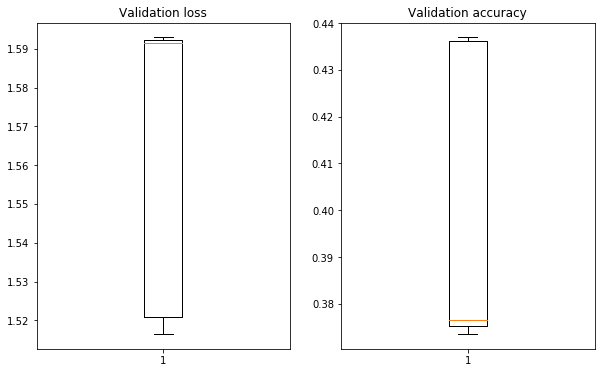

In [76]:
fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2)#, sharey=True)

losses, accuracies = zip(*stats)

ax_loss.boxplot(losses)
ax_loss.set_title("Validation loss")
#ax_loss.set_yticklabels(hidden_neurons) # I am not sure it makes any sense: to build boxplot points are not kept in the same order


ax_acc.boxplot(accuracies)
ax_acc.set_title("Validation accuracy")
#ax_acc.set_yticklabels(hidden_neurons)

Text(0.5,1,'Validation accuracy')

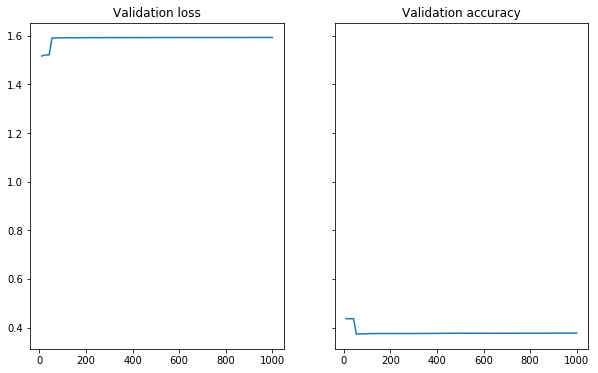

In [77]:
fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2, sharey=True)

ax_loss.plot(hidden_neurons, losses)
ax_loss.set_title("Validation loss")
ax_acc.plot(hidden_neurons, accuracies)
ax_acc.set_title("Validation accuracy")

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

### 1.

#### Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons

In [9]:
def dense_factory(input_, output, weight_regularizer, bias_regularizer):
    return Dense(output, input_shape=(input_,), activation="softmax", kernel_regularizer=weight_regularizer, bias_regularizer=bias_regularizer)

def model_factory(units, layers, batch_normalization, weight_regularizer, bias_regularizer, dropout=None):
    # Check input validity for dropout
    if dropout is not None and len(dropout) < 2:
        dropout.append(0)
        
    model_builder = Sequential()
    
    # Input layer
    model_builder.add(dense_factory(x_train.shape[1], units, weight_regularizer, bias_regularizer)) 
    if dropout is not None:
        model_builder.add(Dropout(dropout[0]))
        
    if batch_normalization is not None:
        model_builder.add(BatchNormalization(momentum=batch_normalization))
        
    # Hidden layers
    for i in range(layers-1):
        model_builder.add(dense_factory((units,), units, weight_regularizer, bias_regularizer))
        if dropout is not None:
            model_builder.add(Dropout(dropout[1]))
            
        if batch_normalization is not None:
            model_builder.add(BatchNormalization(momentum=batch_normalization))
        
    # Output layer
    model_builder.add(dense_factory((units,), y_train.shape[1], weight_regularizer, bias_regularizer))
    if dropout is not None:
        model_builder.add(Dropout(dropout[1]))
        
    if batch_normalization is not None:
        model_builder.add(BatchNormalization(momentum=batch_normalization))
    
    return model_builder

# Dummy regularizer, used as non existing regularizer
null_reg = keras.regularizers.l1(0)

# Factories for required models
size_per_layer_1_hidden = 100
size_per_layer_2_hidden = 77
size_per_layer_3_hidden = 66
size_per_layer_4_hidden = 59

def model_1_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_1_hidden, 1, batch_normalization, weight_regularizer, bias_regularizer, dropout)

def model_2_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_2_hidden, 2, batch_normalization, weight_regularizer, bias_regularizer, dropout)

def model_3_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_3_hidden, 3, batch_normalization, weight_regularizer, bias_regularizer, dropout)

def model_4_hidden_factory(batch_normalization=None, weight_regularizer=None, bias_regularizer=None, dropout=None):
    return model_factory(size_per_layer_4_hidden, 4, batch_normalization, weight_regularizer, bias_regularizer, dropout)

def compile_model(model):
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=Adam(lr=0.01),
        metrics=['accuracy']
    )
    
def fit_model(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    h = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=100,
        verbose=1,
        #callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5, min_delta=0.001)]
        #callbacks=[RealEarlyStopper]
    )   
    return h

#### Confirm you result with the keras method model.summary()

In [10]:
model_1_hidden_factory().summary()
model_2_hidden_factory().summary()
model_3_hidden_factory().summary()
model_4_hidden_factory().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 77)                19789     
_________________________________________________________________
dense_4 (Dense)              (None, 77)                6006      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

### 2.
#### Run each model multiple times with different initial conditions

In [ ]:
model_factories = [model_1_hidden_factory, model_2_hidden_factory, model_3_hidden_factory, model_4_hidden_factory]

try_per_model = 40

results = []

for i, factory in enumerate(model_factories):
    print('Training model', i + 1, '/', len(model_factories))
    
    curr_model_res = []
    
    for i in range(try_per_model):
        print('Inner step:', i+1, '/', try_per_model)
        
        model = factory()
        
        compile_model(model)
        
        h = fit_model(model, x_train, y_train, x_test, y_test)
        
        curr_model_res.append(h)
        
    results.append(curr_model_res)

Training model 1 / 4
Inner step: 1 / 40
Train on 37686 samples, validate on 13278 samples
Epoch 1/100
37686/37686 [==============================] - 3s 68us/step - loss: 1.3622 - acc: 0.4325 - val_loss: 1.2940 - val_acc: 0.4740
Epoch 2/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.2780 - acc: 0.4670 - val_loss: 1.3564 - val_acc: 0.4618
Epoch 3/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.2732 - acc: 0.4693 - val_loss: 1.2929 - val_acc: 0.4779
Epoch 4/100
37686/37686 [==============================] - 2s 55us/step - loss: 1.2698 - acc: 0.4716 - val_loss: 1.3080 - val_acc: 0.4761
Epoch 5/100
37686/37686 [==============================] - 2s 56us/step - loss: 1.2674 - acc: 0.4737 - val_loss: 1.3032 - val_acc: 0.4809
Epoch 6/100
37686/37686 [==============================] - 2s 55us/step - loss: 1.2292 - acc: 0.4987 - val_loss: 1.2484 - val_acc: 0.5044
Epoch 7/100
37686/37686 [==============================] - 2s 59us/step - loss: 1.

37686/37686 [==============================] - 2s 57us/step - loss: 1.1660 - acc: 0.5245 - val_loss: 1.2333 - val_acc: 0.5182
Epoch 18/100
37686/37686 [==============================] - 2s 55us/step - loss: 1.1570 - acc: 0.5328 - val_loss: 1.2147 - val_acc: 0.5272
Epoch 19/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.1562 - acc: 0.5374 - val_loss: 1.2403 - val_acc: 0.5255
Epoch 20/100
37686/37686 [==============================] - 2s 64us/step - loss: 1.1422 - acc: 0.5481 - val_loss: 1.2700 - val_acc: 0.5729
Epoch 21/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.0299 - acc: 0.6133 - val_loss: 1.0280 - val_acc: 0.6243
Epoch 22/100
37686/37686 [==============================] - 2s 51us/step - loss: 0.9209 - acc: 0.6517 - val_loss: 0.9404 - val_acc: 0.6549
Epoch 23/100
37686/37686 [==============================] - 2s 53us/step - loss: 0.8567 - acc: 0.6771 - val_loss: 0.9118 - val_acc: 0.6616
Epoch 24/100
37686/37686 [==============

37686/37686 [==============================] - 2s 57us/step - loss: 0.6100 - acc: 0.7823 - val_loss: 0.7621 - val_acc: 0.7415
Epoch 77/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.6087 - acc: 0.7797 - val_loss: 0.7861 - val_acc: 0.7299
Epoch 78/100
37686/37686 [==============================] - 2s 52us/step - loss: 0.6056 - acc: 0.7832 - val_loss: 0.7606 - val_acc: 0.7478
Epoch 79/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6054 - acc: 0.7833 - val_loss: 0.7608 - val_acc: 0.7451
Epoch 80/100
37686/37686 [==============================] - 2s 60us/step - loss: 0.6070 - acc: 0.7822 - val_loss: 0.7558 - val_acc: 0.7529
Epoch 81/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.6002 - acc: 0.7841 - val_loss: 0.7654 - val_acc: 0.7476
Epoch 82/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.6034 - acc: 0.7841 - val_loss: 0.7530 - val_acc: 0.7513
Epoch 83/100
37686/37686 [==============

37686/37686 [==============================] - 2s 54us/step - loss: 0.5435 - acc: 0.8334 - val_loss: 0.7444 - val_acc: 0.7896
Epoch 94/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.5439 - acc: 0.8355 - val_loss: 0.7182 - val_acc: 0.7916
Epoch 95/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5390 - acc: 0.8362 - val_loss: 0.7129 - val_acc: 0.7950
Epoch 96/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.5451 - acc: 0.8339 - val_loss: 0.7320 - val_acc: 0.7851
Epoch 97/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.5396 - acc: 0.8363 - val_loss: 0.7310 - val_acc: 0.7820
Epoch 98/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.5476 - acc: 0.8351 - val_loss: 0.7355 - val_acc: 0.7851
Epoch 99/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.5403 - acc: 0.8359 - val_loss: 0.7246 - val_acc: 0.7878
Epoch 100/100
37686/37686 [=============

37686/37686 [==============================] - 2s 54us/step - loss: 1.0529 - acc: 0.5531 - val_loss: 1.0587 - val_acc: 0.5590
Epoch 10/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.0510 - acc: 0.5515 - val_loss: 1.0609 - val_acc: 0.5617
Epoch 11/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.0459 - acc: 0.5562 - val_loss: 1.0985 - val_acc: 0.5686
Epoch 12/100
37686/37686 [==============================] - 2s 58us/step - loss: 1.0252 - acc: 0.5727 - val_loss: 1.0344 - val_acc: 0.5871
Epoch 13/100
37686/37686 [==============================] - 2s 58us/step - loss: 0.9954 - acc: 0.5874 - val_loss: 1.0370 - val_acc: 0.5811
Epoch 14/100
37686/37686 [==============================] - 3s 69us/step - loss: 0.9804 - acc: 0.5932 - val_loss: 1.0241 - val_acc: 0.5836
Epoch 15/100
37686/37686 [==============================] - 2s 60us/step - loss: 0.9739 - acc: 0.5961 - val_loss: 1.0509 - val_acc: 0.5767
Epoch 16/100
37686/37686 [==============

37686/37686 [==============================] - 2s 60us/step - loss: 0.5904 - acc: 0.7874 - val_loss: 0.7200 - val_acc: 0.7547
Epoch 69/100
37686/37686 [==============================] - 3s 90us/step - loss: 0.5933 - acc: 0.7874 - val_loss: 0.7136 - val_acc: 0.7564
Epoch 70/100
37686/37686 [==============================] - 3s 71us/step - loss: 0.5876 - acc: 0.7890 - val_loss: 0.7267 - val_acc: 0.7474
Epoch 71/100
37686/37686 [==============================] - 3s 69us/step - loss: 0.5868 - acc: 0.7891 - val_loss: 0.7030 - val_acc: 0.7621
Epoch 72/100
37686/37686 [==============================] - 2s 61us/step - loss: 0.5864 - acc: 0.7899 - val_loss: 0.7515 - val_acc: 0.7503
Epoch 73/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5858 - acc: 0.7891 - val_loss: 0.7292 - val_acc: 0.7460
Epoch 74/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.5833 - acc: 0.7900 - val_loss: 0.7271 - val_acc: 0.7537
Epoch 75/100
37686/37686 [==============

37686/37686 [==============================] - 2s 56us/step - loss: 0.6016 - acc: 0.7868 - val_loss: 0.7642 - val_acc: 0.7465
Epoch 86/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6006 - acc: 0.7864 - val_loss: 0.7301 - val_acc: 0.7521
Epoch 87/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5992 - acc: 0.7879 - val_loss: 0.7559 - val_acc: 0.7486
Epoch 88/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5995 - acc: 0.7865 - val_loss: 0.7548 - val_acc: 0.7451
Epoch 89/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.5995 - acc: 0.7885 - val_loss: 0.7444 - val_acc: 0.7492
Epoch 90/100
37686/37686 [==============================] - 2s 53us/step - loss: 0.5938 - acc: 0.7892 - val_loss: 0.7282 - val_acc: 0.7528
Epoch 91/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5974 - acc: 0.7875 - val_loss: 0.7475 - val_acc: 0.7454
Epoch 92/100
37686/37686 [==============

37686/37686 [==============================] - 3s 68us/step - loss: 1.2341 - acc: 0.4836 - val_loss: 1.0850 - val_acc: 0.5476
Epoch 2/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.0871 - acc: 0.5415 - val_loss: 1.0887 - val_acc: 0.5471
Epoch 3/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.0701 - acc: 0.5474 - val_loss: 1.0735 - val_acc: 0.5535
Epoch 4/100
37686/37686 [==============================] - 2s 55us/step - loss: 1.0633 - acc: 0.5487 - val_loss: 1.0831 - val_acc: 0.5613
Epoch 5/100
37686/37686 [==============================] - 2s 54us/step - loss: 1.0640 - acc: 0.5497 - val_loss: 1.0595 - val_acc: 0.5564
Epoch 6/100
37686/37686 [==============================] - 2s 55us/step - loss: 1.0577 - acc: 0.5498 - val_loss: 1.0649 - val_acc: 0.5566
Epoch 7/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.0567 - acc: 0.5503 - val_loss: 1.0964 - val_acc: 0.5381
Epoch 8/100
37686/37686 [=====================

37686/37686 [==============================] - 2s 54us/step - loss: 0.7337 - acc: 0.7161 - val_loss: 0.8464 - val_acc: 0.6911
Epoch 61/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.7324 - acc: 0.7184 - val_loss: 0.8556 - val_acc: 0.6912
Epoch 62/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.7251 - acc: 0.7203 - val_loss: 0.8763 - val_acc: 0.6832
Epoch 63/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.7302 - acc: 0.7172 - val_loss: 0.8486 - val_acc: 0.6860
Epoch 64/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.7246 - acc: 0.7170 - val_loss: 0.8708 - val_acc: 0.6835
Epoch 65/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.7237 - acc: 0.7235 - val_loss: 0.8863 - val_acc: 0.6898
Epoch 66/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.7168 - acc: 0.7225 - val_loss: 0.8842 - val_acc: 0.7009
Epoch 67/100
37686/37686 [==============

37686/37686 [==============================] - 3s 71us/step - loss: 0.6168 - acc: 0.7833 - val_loss: 0.7768 - val_acc: 0.7407
Epoch 78/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6175 - acc: 0.7834 - val_loss: 0.8062 - val_acc: 0.7279
Epoch 79/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.6149 - acc: 0.7840 - val_loss: 0.7692 - val_acc: 0.7390
Epoch 80/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.6148 - acc: 0.7846 - val_loss: 0.7889 - val_acc: 0.7334
Epoch 81/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.6107 - acc: 0.7858 - val_loss: 0.7906 - val_acc: 0.7298
Epoch 82/100
37686/37686 [==============================] - 3s 66us/step - loss: 0.6142 - acc: 0.7844 - val_loss: 0.7943 - val_acc: 0.7329
Epoch 83/100
37686/37686 [==============================] - 2s 63us/step - loss: 0.6079 - acc: 0.7872 - val_loss: 0.7787 - val_acc: 0.7392
Epoch 84/100
37686/37686 [==============

37686/37686 [==============================] - 2s 55us/step - loss: 0.5624 - acc: 0.7971 - val_loss: 0.7664 - val_acc: 0.7553
Epoch 95/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.5693 - acc: 0.7935 - val_loss: 0.7352 - val_acc: 0.7591
Epoch 96/100
37686/37686 [==============================] - 2s 52us/step - loss: 0.5680 - acc: 0.7964 - val_loss: 0.7348 - val_acc: 0.7588
Epoch 97/100
37686/37686 [==============================] - 2s 53us/step - loss: 0.5632 - acc: 0.7952 - val_loss: 0.7548 - val_acc: 0.7573
Epoch 98/100
37686/37686 [==============================] - 2s 52us/step - loss: 0.5610 - acc: 0.7951 - val_loss: 0.7387 - val_acc: 0.7558
Epoch 99/100
37686/37686 [==============================] - 2s 52us/step - loss: 0.5644 - acc: 0.7949 - val_loss: 0.7522 - val_acc: 0.7568
Epoch 100/100
37686/37686 [==============================] - 2s 53us/step - loss: 0.5609 - acc: 0.7958 - val_loss: 0.7668 - val_acc: 0.7401
Inner step: 11 / 40
Train on 37686 samp

37686/37686 [==============================] - 2s 53us/step - loss: 1.1914 - acc: 0.5156 - val_loss: 1.2471 - val_acc: 0.5114
Epoch 11/100
37686/37686 [==============================] - 2s 53us/step - loss: 1.1839 - acc: 0.5155 - val_loss: 1.2357 - val_acc: 0.5191
Epoch 12/100
37686/37686 [==============================] - 2s 53us/step - loss: 1.1771 - acc: 0.5208 - val_loss: 1.2203 - val_acc: 0.5171
Epoch 13/100
37686/37686 [==============================] - 2s 53us/step - loss: 1.1697 - acc: 0.5294 - val_loss: 1.2158 - val_acc: 0.5273
Epoch 14/100
37686/37686 [==============================] - 2s 53us/step - loss: 1.1627 - acc: 0.5378 - val_loss: 1.2285 - val_acc: 0.5345
Epoch 15/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.1523 - acc: 0.5423 - val_loss: 1.2102 - val_acc: 0.5331
Epoch 16/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.1444 - acc: 0.5472 - val_loss: 1.2244 - val_acc: 0.5350
Epoch 17/100
37686/37686 [==============

37686/37686 [==============================] - 2s 56us/step - loss: 0.6229 - acc: 0.7800 - val_loss: 0.7894 - val_acc: 0.7387
Epoch 70/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6216 - acc: 0.7782 - val_loss: 0.7954 - val_acc: 0.7308
Epoch 71/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6238 - acc: 0.7778 - val_loss: 0.7806 - val_acc: 0.7360
Epoch 72/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6187 - acc: 0.7799 - val_loss: 0.7711 - val_acc: 0.7362
Epoch 73/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6177 - acc: 0.7818 - val_loss: 0.7895 - val_acc: 0.7405
Epoch 74/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.6184 - acc: 0.7800 - val_loss: 0.7774 - val_acc: 0.7414
Epoch 75/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6162 - acc: 0.7821 - val_loss: 0.7572 - val_acc: 0.7436
Epoch 76/100
37686/37686 [==============

37686/37686 [==============================] - 2s 56us/step - loss: 0.6004 - acc: 0.7871 - val_loss: 0.7701 - val_acc: 0.7562
Epoch 87/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5964 - acc: 0.7892 - val_loss: 0.7635 - val_acc: 0.7474
Epoch 88/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5943 - acc: 0.7914 - val_loss: 0.7572 - val_acc: 0.7549
Epoch 89/100
37686/37686 [==============================] - 2s 63us/step - loss: 0.5982 - acc: 0.7884 - val_loss: 0.7524 - val_acc: 0.7458
Epoch 90/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5964 - acc: 0.7905 - val_loss: 0.7933 - val_acc: 0.7332
Epoch 91/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.5967 - acc: 0.7892 - val_loss: 0.7710 - val_acc: 0.7463
Epoch 92/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5927 - acc: 0.7893 - val_loss: 0.7416 - val_acc: 0.7534
Epoch 93/100
37686/37686 [==============

37686/37686 [==============================] - 2s 57us/step - loss: 1.2858 - acc: 0.4691 - val_loss: 1.2867 - val_acc: 0.4791
Epoch 3/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.2548 - acc: 0.4835 - val_loss: 1.3332 - val_acc: 0.4496
Epoch 4/100
37686/37686 [==============================] - 2s 59us/step - loss: 1.2259 - acc: 0.4990 - val_loss: 1.2710 - val_acc: 0.4979
Epoch 5/100
37686/37686 [==============================] - 2s 59us/step - loss: 1.2019 - acc: 0.5088 - val_loss: 1.2679 - val_acc: 0.4980
Epoch 6/100
37686/37686 [==============================] - 2s 57us/step - loss: 1.1932 - acc: 0.5123 - val_loss: 1.2790 - val_acc: 0.4975
Epoch 7/100
37686/37686 [==============================] - 2s 60us/step - loss: 1.1876 - acc: 0.5150 - val_loss: 1.2573 - val_acc: 0.5035
Epoch 8/100
37686/37686 [==============================] - 3s 67us/step - loss: 1.1849 - acc: 0.5158 - val_loss: 1.2743 - val_acc: 0.4996
Epoch 9/100
37686/37686 [=====================

37686/37686 [==============================] - 2s 56us/step - loss: 0.6566 - acc: 0.7462 - val_loss: 0.7801 - val_acc: 0.7146
Epoch 62/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6554 - acc: 0.7471 - val_loss: 0.7723 - val_acc: 0.7302
Epoch 63/100
37686/37686 [==============================] - 2s 58us/step - loss: 0.6544 - acc: 0.7493 - val_loss: 0.7726 - val_acc: 0.7186
Epoch 64/100
37686/37686 [==============================] - 2s 58us/step - loss: 0.6518 - acc: 0.7495 - val_loss: 0.7588 - val_acc: 0.7261
Epoch 65/100
37686/37686 [==============================] - 2s 60us/step - loss: 0.6495 - acc: 0.7506 - val_loss: 0.7680 - val_acc: 0.7265
Epoch 66/100
37686/37686 [==============================] - 2s 60us/step - loss: 0.6481 - acc: 0.7534 - val_loss: 0.7726 - val_acc: 0.7262
Epoch 67/100
37686/37686 [==============================] - 2s 60us/step - loss: 0.6466 - acc: 0.7524 - val_loss: 0.7840 - val_acc: 0.7205
Epoch 68/100
37686/37686 [==============

37686/37686 [==============================] - 2s 64us/step - loss: 0.6754 - acc: 0.7419 - val_loss: 0.8129 - val_acc: 0.7104
Epoch 79/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.6740 - acc: 0.7415 - val_loss: 0.7894 - val_acc: 0.7232
Epoch 80/100
37686/37686 [==============================] - 2s 58us/step - loss: 0.6695 - acc: 0.7428 - val_loss: 0.7879 - val_acc: 0.7170
Epoch 81/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6638 - acc: 0.7467 - val_loss: 0.8148 - val_acc: 0.7100
Epoch 82/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6666 - acc: 0.7469 - val_loss: 0.7779 - val_acc: 0.7171
Epoch 83/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6600 - acc: 0.7488 - val_loss: 0.8074 - val_acc: 0.7190
Epoch 84/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.6644 - acc: 0.7466 - val_loss: 0.7836 - val_acc: 0.7254
Epoch 85/100
37686/37686 [==============

37686/37686 [==============================] - 2s 60us/step - loss: 0.5382 - acc: 0.8270 - val_loss: 0.7312 - val_acc: 0.7743
Epoch 96/100
37686/37686 [==============================] - 2s 58us/step - loss: 0.5308 - acc: 0.8302 - val_loss: 0.6906 - val_acc: 0.7913
Epoch 97/100
37686/37686 [==============================] - 2s 61us/step - loss: 0.5311 - acc: 0.8301 - val_loss: 0.7307 - val_acc: 0.7766
Epoch 98/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.5302 - acc: 0.8319 - val_loss: 0.7205 - val_acc: 0.7878
Epoch 99/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.5299 - acc: 0.8315 - val_loss: 0.7138 - val_acc: 0.7906
Epoch 100/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.5283 - acc: 0.8314 - val_loss: 0.7135 - val_acc: 0.7833
Inner step: 18 / 40
Train on 37686 samples, validate on 13278 samples
Epoch 1/100
37686/37686 [==============================] - 3s 72us/step - loss: 1.1711 - acc: 0.5219 - val_l

37686/37686 [==============================] - 2s 59us/step - loss: 1.0540 - acc: 0.5696 - val_loss: 1.0868 - val_acc: 0.5699
Epoch 12/100
37686/37686 [==============================] - 2s 60us/step - loss: 1.0531 - acc: 0.5662 - val_loss: 1.0800 - val_acc: 0.5585
Epoch 13/100
37686/37686 [==============================] - 2s 58us/step - loss: 1.0498 - acc: 0.5695 - val_loss: 1.0665 - val_acc: 0.5712
Epoch 14/100
37686/37686 [==============================] - 2s 59us/step - loss: 1.0144 - acc: 0.5889 - val_loss: 1.0201 - val_acc: 0.6093
Epoch 15/100
37686/37686 [==============================] - 2s 56us/step - loss: 0.9577 - acc: 0.6202 - val_loss: 1.0265 - val_acc: 0.6007
Epoch 16/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.9352 - acc: 0.6268 - val_loss: 0.9586 - val_acc: 0.6318
Epoch 17/100
37686/37686 [==============================] - 2s 58us/step - loss: 0.8731 - acc: 0.6515 - val_loss: 0.9365 - val_acc: 0.6392
Epoch 18/100
37686/37686 [==============

37686/37686 [==============================] - 2s 55us/step - loss: 0.5904 - acc: 0.7843 - val_loss: 0.7632 - val_acc: 0.7409
Epoch 71/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5926 - acc: 0.7865 - val_loss: 0.7481 - val_acc: 0.7482
Epoch 72/100
37686/37686 [==============================] - 2s 57us/step - loss: 0.5944 - acc: 0.7840 - val_loss: 0.7511 - val_acc: 0.7457
Epoch 73/100
37686/37686 [==============================] - 2s 59us/step - loss: 0.5934 - acc: 0.7843 - val_loss: 0.7292 - val_acc: 0.7521
Epoch 74/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5903 - acc: 0.7850 - val_loss: 0.7556 - val_acc: 0.7491
Epoch 75/100
37686/37686 [==============================] - 2s 53us/step - loss: 0.5917 - acc: 0.7839 - val_loss: 0.7464 - val_acc: 0.7460
Epoch 76/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5899 - acc: 0.7865 - val_loss: 0.7551 - val_acc: 0.7495
Epoch 77/100
37686/37686 [==============

37686/37686 [==============================] - 2s 54us/step - loss: 0.6010 - acc: 0.7862 - val_loss: 0.7659 - val_acc: 0.7461
Epoch 88/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5978 - acc: 0.7891 - val_loss: 0.7411 - val_acc: 0.7549
Epoch 89/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5982 - acc: 0.7901 - val_loss: 0.7728 - val_acc: 0.7408
Epoch 90/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.5976 - acc: 0.7899 - val_loss: 0.7384 - val_acc: 0.7582
Epoch 91/100
37686/37686 [==============================] - 2s 54us/step - loss: 0.5955 - acc: 0.7906 - val_loss: 0.7368 - val_acc: 0.7566
Epoch 92/100
37686/37686 [==============================] - 2s 55us/step - loss: 0.5926 - acc: 0.7914 - val_loss: 0.7694 - val_acc: 0.7537
Epoch 93/100
37686/37686 [==============================] - 2s 61us/step - loss: 0.5908 - acc: 0.7903 - val_loss: 0.7348 - val_acc: 0.7531
Epoch 94/100
37686/37686 [==============

37686/37686 [==============================] - 2s 66us/step - loss: 0.9941 - acc: 0.5855 - val_loss: 1.0142 - val_acc: 0.5831
Epoch 4/100
37686/37686 [==============================] - 3s 67us/step - loss: 0.9839 - acc: 0.5890 - val_loss: 1.0087 - val_acc: 0.5847
Epoch 5/100
37686/37686 [==============================] - 3s 69us/step - loss: 0.9741 - acc: 0.5923 - val_loss: 1.0339 - val_acc: 0.5866
Epoch 6/100
37686/37686 [==============================] - 3s 77us/step - loss: 0.9725 - acc: 0.5920 - val_loss: 1.0028 - val_acc: 0.5897
Epoch 7/100
37686/37686 [==============================] - 3s 70us/step - loss: 0.9625 - acc: 0.5979 - val_loss: 1.0183 - val_acc: 0.5941
Epoch 8/100
37686/37686 [==============================] - 3s 72us/step - loss: 0.9704 - acc: 0.5947 - val_loss: 1.0014 - val_acc: 0.5990
Epoch 9/100
37686/37686 [==============================] - 3s 72us/step - loss: 0.9646 - acc: 0.5973 - val_loss: 1.0151 - val_acc: 0.5882
Epoch 10/100
37686/37686 [====================

#### Plot summary statistics of the best validation loss and accuracy versus the number of hidden layers

In [ ]:
# Not sure about that, val_loss and val_acc in this case are not necessarily linked (not the same epoch)

best_results = [[[min(res.history['val_loss']), max(res.history['val_acc'])] for res in model_res] for model_res in results]

In [ ]:
for i, model_results in enumerate(best_results):
    val_loss, val_acc = list(zip(*model_results))
    plt.hist(val_loss, bins=25)
    plt.title("Distribution of validation's losses for model with " + str(i+1) + " hidden layers")
    plt.show()

In [ ]:
for i, model_results in enumerate(best_results):
    val_loss, val_acc = list(zip(*model_results))
    plt.hist(val_acc, bins=25)
    plt.title("Distribution of validation's accuracy for model with " + str(i+1) + " hidden layers")
    plt.show()

In [ ]:
best_trainings = []

for model_results in results:
    best_accs = [max(training_history.history['val_acc']) for training_history in model_results]
    best_training = model_results[best_accs.index(max(best_accs))]
    best_trainings.append(best_training)

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [ ]:
batch_normalization = [0.9, 0.5]
weight_l1_regularizations = [10, 1.0, 0.1, 0.01, 0.001]
weight_l2_regularizations = [10, 1.0, 0.1, 0.01, 0.001]

bias_l1_regularizations = [10, 1.0, 0.1, 0.01, 0.001]
bias_l2_regularizations = [10, 1.0, 0.1, 0.01, 0.001]

dropouts = [[0.2, 0.5], [0.2, 0.9], [0.1, 0.1]]

def grid_search(model_factory, compiler, model_fiter):
    histories = []
    
    def inner_loop(*param_lists):
        for w_reg, b_reg, dropout in itertools.product(*param_lists):
            print(w_reg, b_reg, dropout)
            model = model_factory(keras.regularizers.l1(w_reg), keras.regularizers.l1(b_reg), dropout=dropout)
            compiler(model)
            h = model_fiter(model)
            histories.append(h)
            
    inner_loop(weight_l1_regularizations, bias_l1_regularizations, dropouts)
    inner_loop(weight_l2_regularizations, bias_l1_regularizations, dropouts)
    inner_loop(weight_l1_regularizations, bias_l2_regularizations, dropouts)
    inner_loop(weight_l2_regularizations, bias_l2_regularizations, dropouts)
    
    return histories

In [ ]:
model_family = [model_1_hidden_factory, model_4_hidden_factory]

results = []
for model in model_family:
    res = grid_search(model, compile_model, fit_model)
    results.append(res)

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [ ]:
train_tensor = np.reshape(x_train, (x_train.shape[0], 16, 16, 1))
test_tensor = np.reshape(x_test, (x_test.shape[0], 16, 16, 1))

In [ ]:
cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_tensor.shape[1:]),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.Adadelta(),
           metrics=['accuracy'])

In [ ]:
cnn.fit(
    train_tensor, y_train,
    validation_data=(test_tensor, y_test),
    epochs=20    
)